In [1]:
from databricks import sql
import os
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, DoubleType
from pyspark.sql.functions import when, col, udf, hour, date_format
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc, log_loss
import pandas as pd

In [2]:
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
connection = sql.connect(
                        server_hostname = os.getenv("server_hostname"),
                        http_path = os.getenv("http_path"),
                        access_token = os.getenv("access-token")
)
cursor = connection.cursor()

## Data Cleaning and Data Featuring

In [4]:
spark = SparkSession.builder \
  .appName("logs") \
  .config("spark.driver.memory", "8g") \
  .config("spark.executor.memory", "4g") \
  .config("spark.executor.instances", 4) \
  .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [5]:
cursor = cursor.execute("SELECT * from hive_metastore.logs.http_logs where response_time is not null;")
results = cursor.fetchall()

In [6]:
schema = StructType([
    StructField("http_auth", StringType(), True),
    StructField("ingest_time", StringType(), True),
    StructField("http_method", StringType(), True),
    StructField("resource", StringType(), True),
    StructField("timestamp_request", TimestampType(), True),
    StructField("organization", StringType(), True),
    StructField("timestamp_response", TimestampType(), True),
    StructField("response_time", StringType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("http_url", StringType(), True),
    StructField("source_ip", StringType(), True),
    StructField("_file", StringType(), True),
    StructField("_fivetran_synced", TimestampType(), True),
    StructField("_modified", TimestampType(), True),
    StructField("_line", LongType(), True)
 ])

In [8]:
df = spark.createDataFrame(results, schema)

In [10]:
del cursor, results

In [11]:
table_name = "logs"
df.createOrReplaceTempView(table_name)

In [12]:
start_date = datetime.datetime(2022, 12, 1, 0, 0)
end_date = datetime.datetime(2023, 1, 1, 0, 0)
df = df.filter((col('timestamp_request') >= start_date) & (col('timestamp_request') <= end_date))

In [13]:
def convert_to_seconds(interval):
    if isinstance(interval, datetime.timedelta):
        return interval.total_seconds()
    else:
        return interval.milliseconds / 1000
convert_to_seconds_udf = udf(convert_to_seconds, DoubleType())

In [15]:
df = df.withColumn('Response_Time', col('timestamp_response') - col('timestamp_request'))
df = df.withColumn("Response_Time_Seconds", convert_to_seconds_udf(col("Response_Time")))
quantiles = df.approxQuantile("Response_Time_Seconds", [0.25, 0.75], 0.05)

Q1, Q3 = quantiles
IQR = Q3 - Q1

lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR

df = df.withColumn('load_factor', when(col('Response_Time_Seconds') > ub, 1).otherwise(0))

In [16]:
df = df.withColumn('Transformed_HTTP_Auth', 
                   when(col('http_auth').contains('USER_KEY'), 0).otherwise(1))

In [17]:
org = df.groupBy('Organization') \
                      .count() \
                      .orderBy(col('count').desc()) \
                      .limit(10)

In [18]:
ls = org.select('Organization').rdd.flatMap(lambda x: x).collect()
del org

In [19]:
df = df.filter(col('Organization').isin(ls))
del ls

In [20]:
df = df.withColumn('day_name', date_format(col('timestamp_request'), 'EEEE'))

In [21]:
def time_periods(hour):
    if 0 <= hour < 3:
        return 'Late Night'
    elif 3 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 9:
        return 'Morning'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

time_periods_udf = udf(time_periods, StringType())
df = df.withColumn('hour', hour(col('timestamp_request')))
df = df.withColumn('time_period', time_periods_udf(col('hour')))

In [22]:
columns_to_encode = ['http_method','time_period','resource','day_name']
def create_dummy_variables(df, columns):
    for col_name in columns:
        unique_values = df.select(col_name).distinct().rdd.flatMap(lambda x: x).collect()
        for value in unique_values:
            df = df.withColumn(f"{col_name}_{value}", when(col(col_name) == value, 1).otherwise(0))
    return df
df = create_dummy_variables(df, columns_to_encode)

In [23]:
columns_to_drop = ['http_auth', 'ingest_time', 'http_method',  'resource', 'timestamp_request', 'organization',
                   'timestamp_response',   'Response_Time', 'event_time',   'http_url',  'source_ip',
                    '_file', '_fivetran_synced', '_modified', '_line','Response_Time_Seconds','day_name','hour','time_period']
df = df.drop(*columns_to_drop)

In [24]:
df.show(2)

+-----------+---------------------+-----------------+----------------+----------------+---------------+--------------------------+-------------------+-------------------------+---------------------+------------------------+----------------------+-------------------+-----------------+--------------------------------------------+----------------------------------------+--------------------------------------------+---------------------------------------+---------------------------------+-----------------------------+------------------------------------------+-------------------------------------------+-------------------------------------------+---------------------------------+--------------------------------------+----------------------------------------+-------------------------+-----------------+---------------+-----------------+---------------+---------------+
|load_factor|Transformed_HTTP_Auth|http_method_PATCH|http_method_POST|http_method_HEAD|http_method_GET|time_period_Late After

In [25]:
df = df.toPandas()

# Predictive Analytics

In [26]:
#==================Predictor Variables=====================================
X = df.drop(columns = ['load_factor'], axis=1)
#===================Output Variable========================================
y = df['load_factor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)

In [27]:
accuracies = []
total_time = []

## Logistic Regression

In [28]:
clf_LR = LogisticRegression(max_iter = 10000)

start = time.time()
clf_LR.fit(X_train, y_train)
end = time.time()

y_pred_LR = clf_LR.predict(X_test)
accuracy_LR = accuracy_score(y_test, y_pred_LR)
execution_time = end - start
accuracies.append(['Logistic Regression', accuracy_LR])
total_time.append(['Logistic Regression',execution_time])
print("Accuracy:", accuracy_LR)
print("Execution Time: ", execution_time)

Accuracy: 0.9354087248160281
Execution Time:  63.72515392303467


### Confusion Matrix

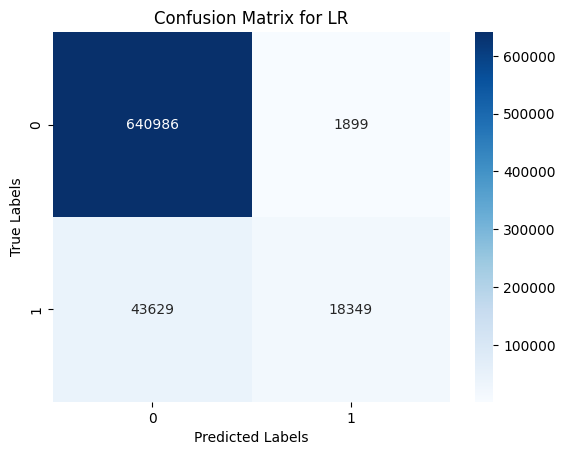

In [29]:
cm = confusion_matrix(y_test, y_pred_LR)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for LR')
plt.show()

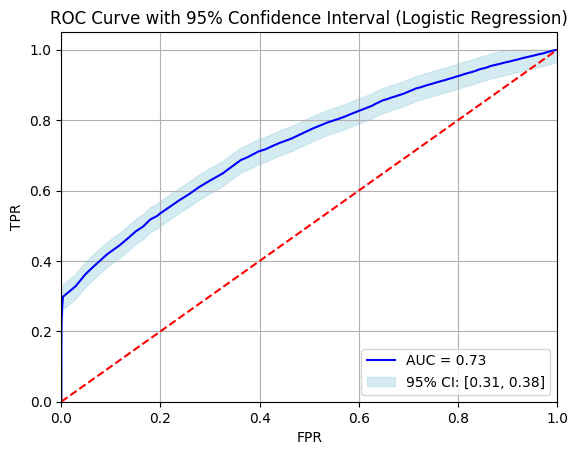

In [30]:
#==========================ROC Curve Logistic Regression==========================
y_pred_prob = clf_LR.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [31]:
#====================================Logistic Regression Classification Report===============
report_LR = classification_report(y_test, y_pred_LR)
print(report_LR)
#==============================================================================================

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    642885
           1       0.91      0.30      0.45     61978

    accuracy                           0.94    704863
   macro avg       0.92      0.65      0.71    704863
weighted avg       0.93      0.94      0.92    704863



## Decision Tree

In [32]:
clf_DT = DecisionTreeClassifier()
clf_DT.fit(X_train, y_train)

start = time.time()
y_pred_DT = clf_DT.predict(X_test)
end = time.time()

accuracy = accuracy_score(y_test, y_pred_DT)
execution_time = end - start

accuracies.append(['Decision Tree', accuracy])
total_time.append(['Decision Tree',execution_time])

print("Accuracy:", accuracy)
print("Execution Time: ", execution_time)

Accuracy: 0.9354243306855374
Execution Time:  0.08408379554748535


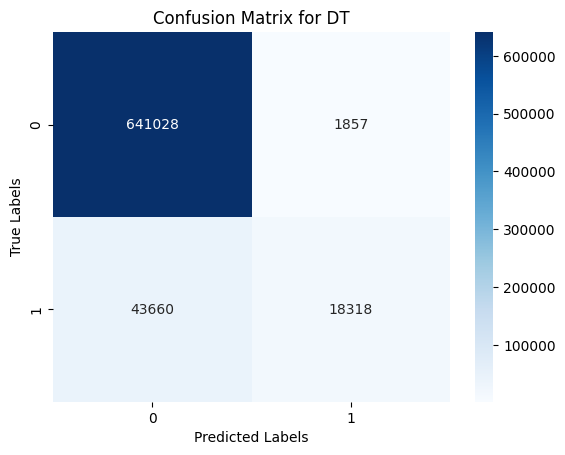

In [33]:
cm = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for DT')
plt.show()

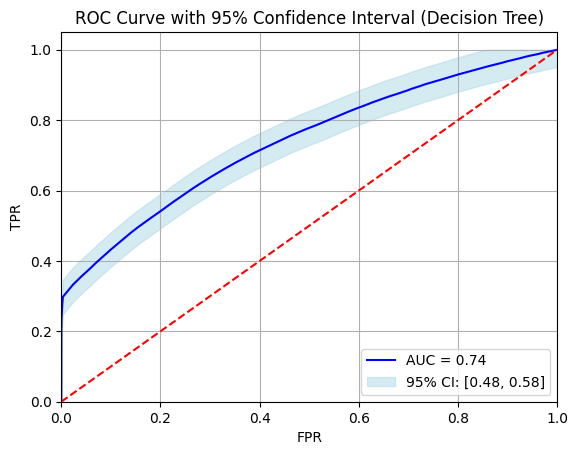

In [34]:
#==========================ROC Curve Decision Tree==========================
y_pred_prob = clf_DT.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Decision Tree)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [35]:
#====================================Decision Tree Classification Report===============
report_DT = classification_report(y_test, y_pred_DT)
print(report_DT)
#==============================================================================================

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    642885
           1       0.91      0.30      0.45     61978

    accuracy                           0.94    704863
   macro avg       0.92      0.65      0.71    704863
weighted avg       0.93      0.94      0.92    704863



## Gradient Boosting Classifier

In [36]:
#=================================Gradient Boosting Model=====================
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(X_train, y_train)

start = time.time()
y_pred_gbm = gbm.predict(X_test)
end = time.time()

accuracy = accuracy_score(y_test, y_pred_gbm)
execution_time = end - start

accuracies.append(['Gradient Boosting Classifier', accuracy])
total_time.append(['Gradient Boosting Classifier',execution_time])

print("Accuracy:", accuracy)
print("Execution Time: ", execution_time)

Accuracy: 0.9354073061006182
Execution Time:  1.193845510482788


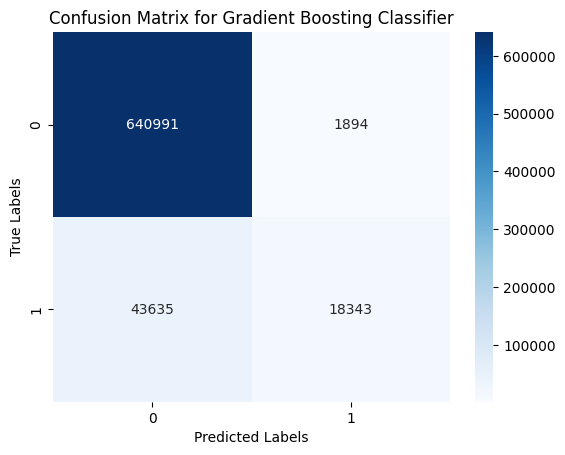

In [37]:
cm = confusion_matrix(y_test, y_pred_gbm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.show()

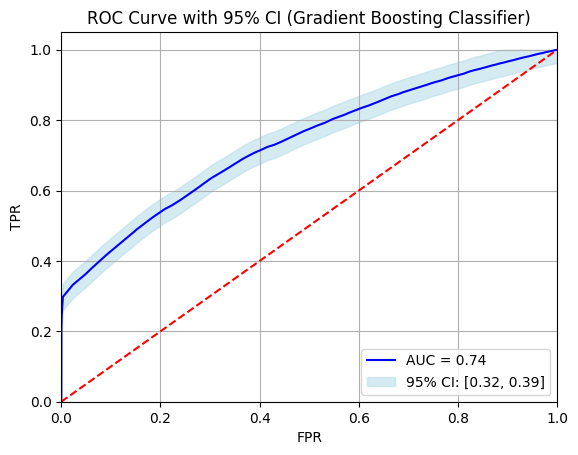

In [38]:
#==========================ROC Curve Gradient Boosting Classifier==========================
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% CI (Gradient Boosting Classifier)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Light GBM

In [39]:
##==========================Light GBM ===================================
train_data = lgb.Dataset(X_train, label=y_train)
# Defining the LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'lambda_l2': 0.1,  # Ridge Regularization
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

start = time.time()
model = lgb.train(params, train_data, num_boost_round=100)
end = time.time()
y_pred_lgb = model.predict(X_test)

y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_lgb]
accuracy = accuracy_score(y_test, y_pred_binary)
execution_time = end - start

accuracies.append(['Light GBM', accuracy])
total_time.append(['Light GBM',execution_time])

print("Accuracy for Light GBM:", accuracy)
print("Execution Time: ", execution_time)

Accuracy for Light GBM: 0.9354158183930779
Execution Time:  11.572189092636108


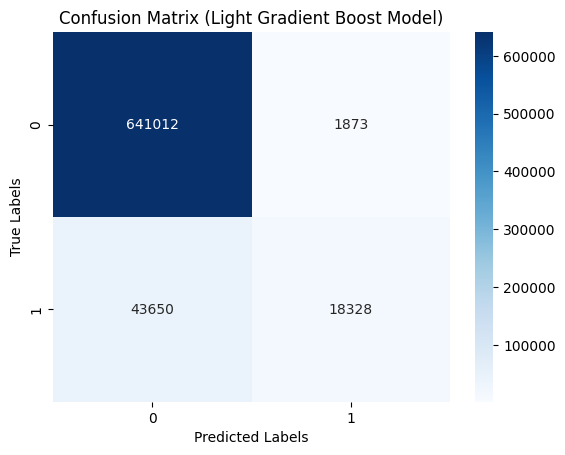

In [40]:
#===============================Confusion Matrix LGB=======================
cm = confusion_matrix(y_test, y_pred_binary)
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix (Light Gradient Boost Model)')
plt.show()
#=========================================================================

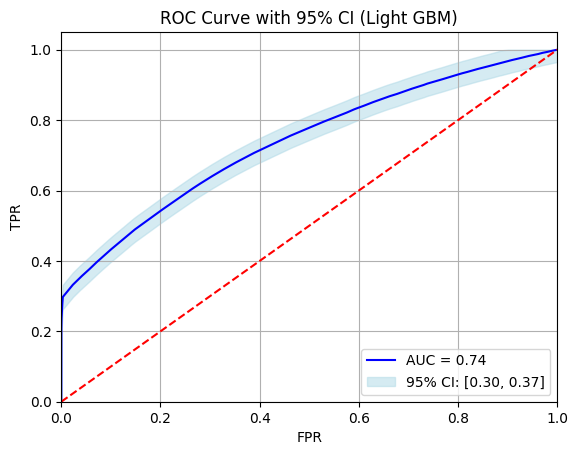

In [41]:
#============================ROC Curve for lightGBM model=============================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% CI (Light GBM)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [43]:
import pandas as pd
#=====================Creating dataFrame based on accuracies of model==========================
df_acc =  pd.DataFrame(accuracies,columns=['Model','Accuracy'])
#=========Creating dataframe for model execution time================
df_exec_time =  pd.DataFrame(total_time,columns=['Model','ExecutionTime'])

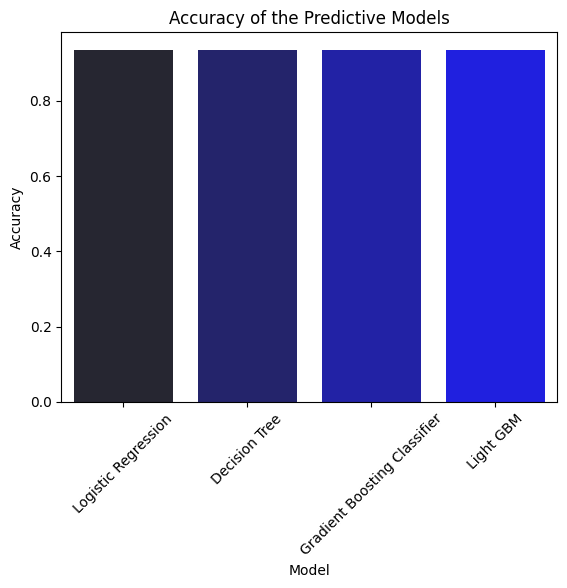

In [46]:
sns.barplot(data=df_acc, x='Model', y='Accuracy', hue='Model', color='blue')
plt.title('Accuracy of the Predictive Models')
plt.xticks(rotation = 45)
plt.show()

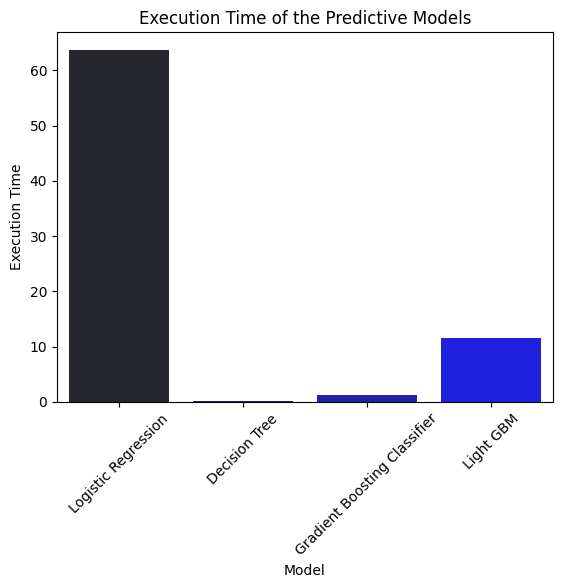

In [49]:
sns.barplot(data=df_exec_time, x='Model', y='ExecutionTime', hue='Model', color='blue')
plt.title('Execution Time of the Predictive Models')
plt.xlabel('Model')
plt.ylabel('Execution Time')
plt.xticks(rotation = 45)
plt.show()